# The Ising model
In this notebook, different algorithms are used trying to simulate the ising model

# Lattice

In [ ]:
class LatticeInterface:
  """Stores spin lattice data"""

  def getN(self) -> int:
    """Returns the number of lattice points"""
    pass

  def getJ(self) -> float:
    """Returns the parameter J"""
    pass

  def getSpin(self, i: int) -> int:
    """Returns the spin state [-1, 1] of the specified lattice point"""
    pass

  def setSpin(self, i: int, spin: int):
    """Sets the spin state [-1, 1] of the specified lattice point"""
    pass

  def getNeighbors(self, i: int) -> list[int]:
    """Returns a list of indices of the neighbors of the specified lattice point"""
    pass

  #def clone(self) -> LatticeInterface:
    """Returns a copy of this LatticeInterface"""
    #pass

  def flipSpin(self, i: int):
    """Flips the spin state [-1, 1] of the specified lattice point"""
    if (self.getSpin(i) == 1):
      self.setSpin(i, -1)
    else:
      self.setSpin(i, 1)

  def getE(self) -> float:
    """Returns the value of the Hamiltonian H"""
    sum = 0
    for i in range(self.getN()):
      for j in self.getNeighbors(i):
        sum += self.getSpin(i) * self.getSpin(j)
    return sum * (-self.getJ())

  def getM(self) -> float:
    """Returns the value of the average magnetization M"""
    sum = 0
    for i in range(self.getN()):
      sum += self.getSpin(i)
    return sum / self.getN()

In [ ]:
import numpy as np

class MatrixLattice(LatticeInterface):

  _rows = None
  _cols = None
  _J = None
  _lattice = None

  def __init__(self, J: float, r: int, c: int = None):
    """constructor"""
    self._J = J
    self._rows = r
    self._cols = r if (c == None) else c
    self.generateLattice()

  def getN(self) -> int:
    """Returns the number of lattice points"""
    return self._rows * self._cols

  def getJ(self) -> float:
    """Returns the parameter J"""
    return self._J

  def getSpin(self, i: int) -> int:
    """Returns the spin state [-1, 1] of the specified lattice point"""
    r, c = self._rc(i)
    return self._lattice[r][c]

  def setSpin(self, i: int, spin: int):
    """Sets the spin state [-1, 1] of the specified lattice point"""
    r, c = self._rc(i)
    self._lattice[r][c] = spin

  def getNeighbors(self, i: int) -> list[int]:
    """Returns a list of indices of the neighbors of the specified lattice point"""
    r,c = self._rc(i)

    n_out = []
    if (r > 0):
      n_out.append(self._index(r - 1, c))
    else:
      n_out.append(self._index(self._rows - 1, c))
    if (r < self._rows - 1):
      n_out.append(self._index(r + 1, c))
    else:
      n_out.append(self._index(0, c))
    if (c > 0):
      n_out.append(self._index(r, c - 1))
    else:
      n_out.append(self._index(r, self._cols - 1))
    if (c < self._cols - 1):
      n_out.append(self._index(r, c + 1))
    else:
      n_out.append(self._index(r, 0))

    return n_out

  def clone(self) -> LatticeInterface:
    newLattice = MatrixLattice(self._J, self._rows, c=self._cols)

    for i in range(self.getN()):
      r,c=self._rc(i)
      newLattice.setSpin(i, self.getSpin(i))

    return newLattice

  def _rc(self, i: int) -> tuple[int, int]:
    return int(np.floor(i / self._cols)), int(np.floor(i % self._cols))

  def _index(self, row: int, col: int) -> int:
    return int((self._cols * row) + col)

  def _exists(self, r: int, c: int) -> bool:
    return r >= 0 and r < self._rows and c >= 0 and c < self._cols

  def generateLattice(self):
    """Generates the lattice with size n by n with each lattice point being 1 or -1"""
    self._lattice = np.random.choice([-1,1], size = (self._rows, self._cols))

#Algorithms

## Metropolis

In [ ]:
import numpy as np
import random

def metropolisAlgorithm(lattice: LatticeInterface, kB: float, T: float, nCycles: int) -> tuple[list[float], list[float]]:
  energies = []
  avgMag = []

  E = lattice.getE()
  energies.append(E)
  for n in range(nCycles):
    for i in range(lattice.getN()):# Pick a lattice site i
      lattice.flipSpin(i)# Flip the spin at that site
      E1 = lattice.getE()
      deltaE = E1 - E# Calculate the change in energy ΔE
      if (deltaE < 0 or (random.random() < np.exp(-deltaE/(kB*T)))):
        pass# Accept the move
      else:
        lattice.flipSpin(i)# Swap the spin back

      E = E1
    energies.append(E)
    avgMag.append(lattice.getM())
  return energies, avgMag

## Wolff

In [ ]:
## This code was written using ChatGPT by feeding a detailed pseudocode outline and the beginning of an implementation scheme.
## This is testable once main() is completed and should work properly.
## I cleaned up the ChatGPT code and this SOMETIMES works.
# TODO: Fix the wraparound. Indices get out of bounds sometimes.

# Basic pseudocode outline:
# 1. Choose a random single site to build a cluster
# 2. Consider links to initial site:
#       p_l_min = 0
#       p_l_plus = 1 - exp(-2*beta*sigma_min*sigma_plus)
# 3. Given set of sites added to cluster in previous update, consider links to sites outside cluster:
#       Activate l_plus links with probabilty p_l_plus
# 4. Loop back to Step 3 until set of links left for activation in next round is empty.
# 5. Flip whole cluster with probability 1. Loop back to step 1.

# from random import randint, exp
import random

def wolffAlgorithm(lattice: LatticeInterface, beta: float, T: float, nCycles: int) -> tuple[list[float], list[float]]:
    energies = [] # Initialize energies array
    avgMag = []
    E = lattice.getE()
    energies.append(E) # Add initial energy of lattice to energies array
    avgMag.append(lattice.getM())
    N = lattice.getN() # Get size of lattice - or should this be sqrt(N) ?

    def activate_links(curr, cluster, activated):
        neighbors = lattice.getNeighbors(curr) # Create an array of 4 neighbors

        for neighbor in neighbors: # Loop through the 4 neighbors
            # If neighbor is not part of cluster and not activated, run probabilistic analysis
            if not cluster[neighbor] and not activated[neighbor]: ### MAY BE WRONG - wraparound
                # n_idx = lattice[neighbor]
                if lattice.getSpin(neighbor) == lattice.getSpin(curr): # Only give probability >= zero if neighbor and current have same spin
                    p_activate = 1 - np.exp(-2 * beta) # I don't think this is correct ? Should incorporate spins I think. Maybe not because they already are.
                    if p_activate > random.random():
                        cluster[neighbor] = 1 # Add the activated neighbor to the cluster...
                        activated[neighbor] = 1 # and activate it.
                        activate_links(neighbor, cluster, activated) # Run activate_links again recursively on the activated neighbor

    for _ in range(nCycles): # Loop nCycles times
        curr = random.randint(0, N-1) # Chooses a random initial point

        cluster = [0 for _ in range(N)] # Creates an array of N zeros
        activated = [0 for _ in range(N)] # Creates an array of N zeros

        cluster[curr - 1] = 1 # Adds the current point to the cluster ## IS -1 CORRECT???
        activate_links(curr, cluster, activated) # Runs activate_links() on the current point

        for i in range(N): # Loop through the entire lattice and flip the spins of every point in the cluster
            if cluster[i]:
                lattice.flipSpin(i)

        E = lattice.getE() # Get the energy of the entire lattice and append to the energies array
        energies.append(E)
        avgMag.append(lattice.getM())


    return energies, avgMag


# Misc

In [ ]:
def testAlgorithm(name, lattice, algorithm, plot) -> tuple[list[float],list[float]]:
  energies, avgMag = algorithm(lattice)

  energiesPlot = plot
  magPlot = plot

  energiesPlot.plot(energies)
  energiesPlot.xlabel('Step')
  energiesPlot.ylabel('Energy (J)')
  energiesPlot.title(f'{name} Energy vs Step')
  energiesPlot.show()

  magPlot.plot(avgMag)
  magPlot.xlabel('Step')
  magPlot.ylabel('Average Magnetization')# A/m?
  magPlot.title(f'{name} Average Magnetization vs Step')
  magPlot.show()

  return energies, avgMag

def runMetropolis(lattice, plot, N, T, kB) -> tuple[list[float],list[float]]:
  name = f'Metropolis (T={T}K)'
  return testAlgorithm(name, lattice.clone(), lambda x: metropolisAlgorithm(x, kB, T, N), plot)

def runWolff(lattice, plot, N, T, beta) -> tuple[list[float],list[float]]:
  name = f'Wolff (T={T}K)'
  return testAlgorithm(name, lattice.clone(), lambda x: wolffAlgorithm(x, beta, T, N), plot)

# Main

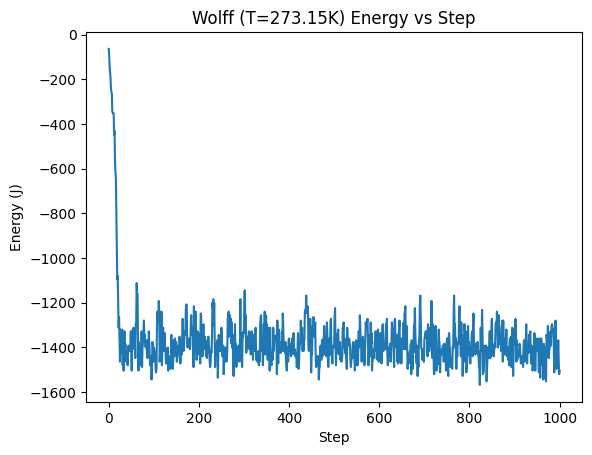

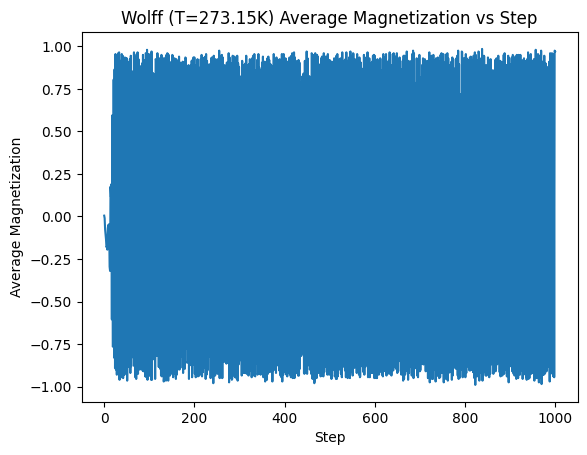

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

param_N = 20
param_T = 273.15
param_kB = 1.380649E-23
param_J = 1
param_ncycles = 1000
param_beta = 0.5 # Guess

#
# Create the lattice using the parameters
#
globalLattice = MatrixLattice(param_J, param_N)

#
# Run the algorithms on the lattice
#

#energies_m, mag_m = runMetropolis(globalLattice, plt, param_ncycles, param_T, param_kB)
energies_w, mag_w = runWolff(globalLattice, plt, param_ncycles, param_T, param_beta)

# Animate

In [ ]:
from matplotlib import animation, rc
from IPython.display import HTML

def animate_metropolis(lattice, kB, T, nCycles):
    """Make the plot itself"""
    fig, ax = plt.subplots()

    def update(frame):
        nonlocal E
        """Iterate over all the lattice points"""
        for i in range(lattice.getN()):
            """Flip the spin of some randome lattice point and calculate deltaE"""
            lattice.flipSpin(random.randint(0, lattice.getN() - 1))
            E1 = lattice.getE()
            deltaE = E1 - E
            """Decide if we should accept the flip"""
            if (deltaE < 0 or (random.random() < np.exp(-deltaE / (kB * T)))):
                E = E1

        ax.clear()
        """Display current lattice frame"""
        ax.imshow(lattice._lattice, cmap='binary', interpolation='nearest')
        ax.set_title(f"Step {frame}")
        return ax

    E = lattice.getE()
    """make animation"""
    ani = animation.FuncAnimation(fig, update, frames=nCycles, interval=200, repeat=False)
    return ani

lattice = MatrixLattice(param_J, param_N, c=param_N)

ani = animate_metropolis(lattice, param_kB, param_T, param_ncycles)
"""Display using HTML"""
HTML(ani.to_jshtml())

In [ ]:
def animate_wolff(lattice, beta, T, nCycles):
    fig, ax = plt.subplots()
    ax.set_xticks([])
    ax.set_yticks([])

    def update(frame):
        nonlocal energies  # Declare energies as non-local variable
        curr = random.randint(0, lattice.getN() - 1)  # Choose a random initial point

        cluster = [0 for _ in range(lattice.getN())]  # Create an array to track the cluster
        activated = [0 for _ in range(lattice.getN())]  # Create an array to track activated sites

        cluster[curr] = 1  # Add the initial point to the cluster
        activate_links(curr, cluster, activated)  # Activate links recursively

        for i in range(lattice.getN()):  # Loop through the lattice and flip spins in the cluster
            if cluster[i]:
                lattice.flipSpin(i)

        E = lattice.getE()  # Get the energy of the lattice
        energies.append(E)

        ax.clear()
        ax.imshow(lattice._lattice, cmap='binary', interpolation='nearest')
        ax.set_title(f"Step {frame}")
        return ax

    energies = []  # Initialize energies array
    lattice.generateLattice()  # Generate the lattice
    ani = animation.FuncAnimation(fig, update, frames=nCycles, interval=200, repeat=False)
    return ani

# Example usage
lattice = MatrixLattice(param_N, param_N, param_J)
ani = animate_wolff(lattice, param_beta, param_T, param_ncycles)
HTML(ani.to_jshtml())